Channel number?: W1=0 , W2=1 
0
Oscilloscope number?: T1=0, T2=1, both=2, Reset=3 
0
반복할 횟수=?1
Opening first device...
							 1
waveform 을 입력하세요: funcSine,funcDC funcTriangle...
funcSine
Offset 을 입력하세요: V
0
Frequency 를 입력하세요: Hz
500
Amplitude 를 입력하세요: V
2.5
funcSine 500.0 Hz 2.5 V Amplitude 0.0 V offset
Generating
AUX:	0.0V	0.0A
Starting oscilloscope
record 0.48744964599609375 secs
Recording done


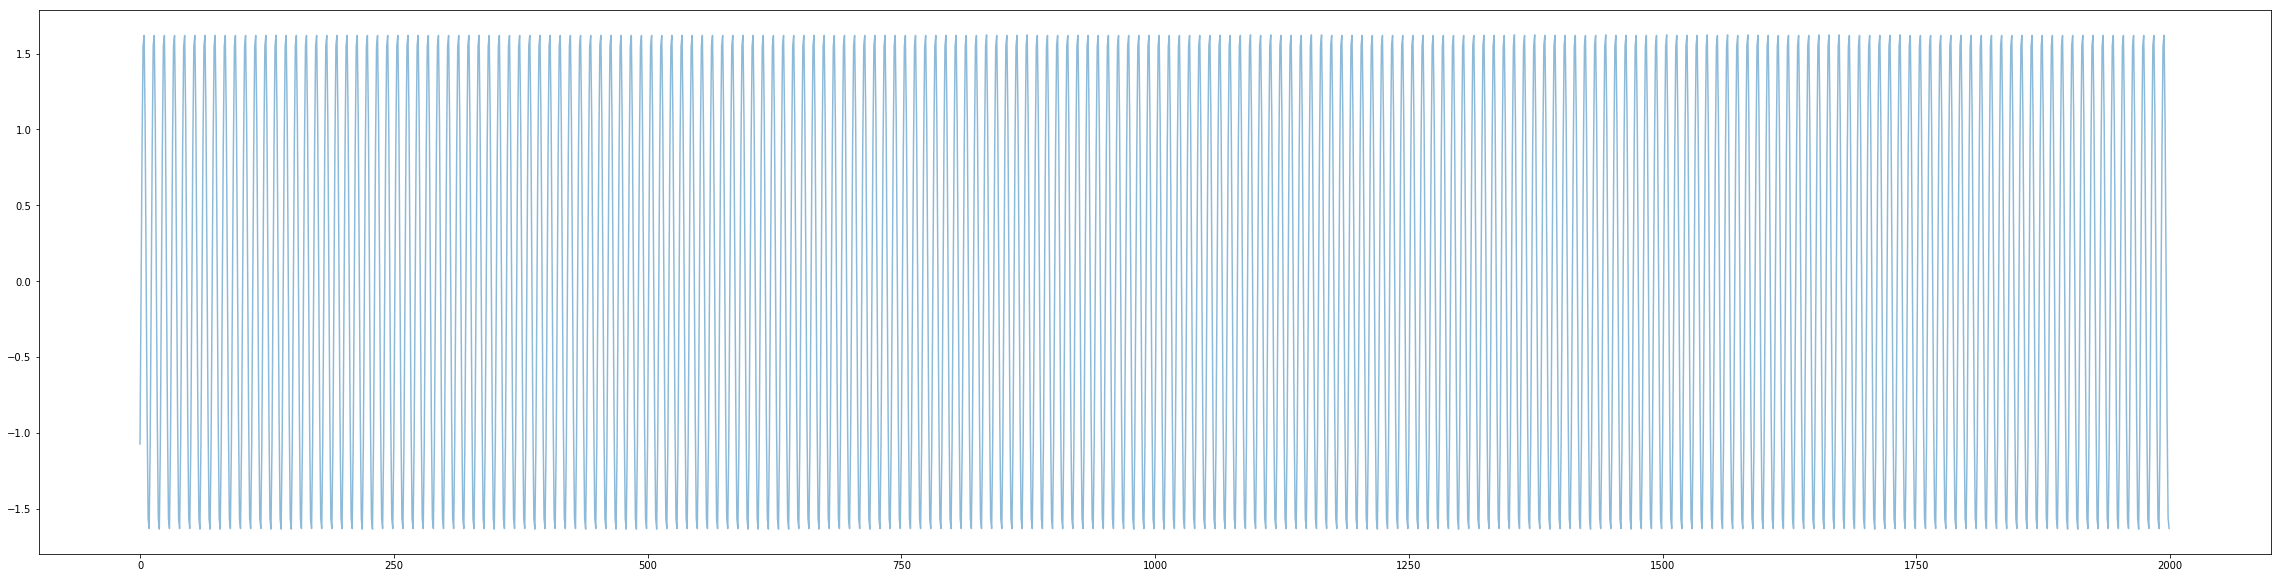

Mean -0.007115552575175112
Mean1 0
V 0.0


In [7]:
import os
def write_txt(list,fname,sep):

    file=open(fname,'w')
    vstr=''
    
    for a in list:
        vstr = vstr + str(a) +sep 
    vstr = vstr.rstrip(sep)
    
    file.writelines(vstr)
    file.close()
    print('[파일 저장 완료]')
#Ref: https://data-make.tistory.com/109

#%%
from ctypes import *
import time
import sys
from datetime import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import numpy
import os 
os.chdir('C:/Users/jhoon/JH/Electronics and Measurement Techniques/Data/') #import 장소
from dwfconstants import *


if sys.platform.startswith("win"):
    dwf = cdll.dwf
elif sys.platform.startswith("darwin"):
    dwf = cdll.LoadLibrary("/Library/Frameworks/dwf.framework/dwf")
else:
    dwf = cdll.LoadLibrary("libdwf.so")
#dll 불러오기
WaveNum=int(input('Channel number?: W1=0 , W2=1 \n'))
OscilNum=int(input('Oscilloscope number?: T1=0, T2=1, both=2, Reset=3 \n'))
WaveChannel = c_int(WaveNum)
OscilChannel= c_int(OscilNum)

nSamples = 2000
rgdSamples=(c_double*nSamples)() # Os1
rgdSamples1=(c_double*nSamples)()  #Os2
hzAcq= c_double(5000)# Acquired data per sec

hdwf = c_int() #handle 
sts= c_byte() #AnalogIn status info
cAvailable = c_int()
cBufMax=c_int()
cLost = c_int()
cCorrupted = c_int()
fLost =0 
fCorrupted = 0

if OscilNum==3:
    print('초기화')
                
    dwf.FDwfAnalogOutReset(hdwf, WaveChannel)
    dwf.FDwfDeviceCloseAll()
#초기화하기 위함

#version = create_string_buffer(16)
#dwf.FDwfGetVersion(version)
#print("DWF Version: "+str(version.value))

#open device


k=0
repeat= int(input('반복할 횟수=?'))

MEANDATA=[]
MEANDATA1=[]

DEVDATA=[]
DEVDATA1=[]

VOLTDATA=[]
VOLTDATA1=[]



while k < repeat:
    print("Opening first device...")
    print('\t\t\t\t\t\t\t',k+1)

    dwf.FDwfDeviceOpen(c_int(-1), byref(hdwf))
    
    
    if hdwf.value == hdwfNone.value:
        print("failed to open device")
        break;
    if k ==0:
        dwf.FDwfAnalogOutNodeEnableSet(hdwf, WaveChannel, AnalogOutNodeCarrier, c_bool(True))
    # Waveform
        f=input('waveform 을 입력하세요: funcSine,funcDC funcTriangle...\n')    
        offset=float(input('Offset 을 입력하세요: V\n'))

        if f=='funcSine':        
            dwf.FDwfAnalogOutNodeFunctionSet(hdwf, WaveChannel, AnalogOutNodeCarrier, funcSine)
            
            # Hz
            Hz=float(input('Frequency 를 입력하세요: Hz\n'))
            dwf.FDwfAnalogOutNodeFrequencySet(hdwf, WaveChannel, AnalogOutNodeCarrier, c_double(Hz))
            #Amplitude
            Amp=float(input('Amplitude 를 입력하세요: V\n'))
            dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, WaveChannel, AnalogOutNodeCarrier, c_double(Amp))
            print(f, Hz,'Hz', Amp,'V Amplitude', offset,'V offset')
        elif f=='funcTriangle':
            dwf.FDwfAnalogOutNodeFunctionSet(hdwf, WaveChannel, AnalogOutNodeCarrier, funcTriangle)

                # Hz
            Hz=float(input('Frequency 를 입력하세요: Hz\n'))
            dwf.FDwfAnalogOutNodeFrequencySet(hdwf, WaveChannel, AnalogOutNodeCarrier, c_double(Hz))
            #Amplitude
            Amp=float(input('Amplitude 를 입력하세요: V\n'))
            dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, WaveChannel, AnalogOutNodeCarrier, c_double(Amp))
            print(f, Hz,'Hz', Amp,'V Amplitude', offset,'V offset')
        elif f == 'funcDC':  
            dwf.FDwfAnalogOutNodeFunctionSet(hdwf, WaveChannel, AnalogOutNodeCarrier, funcDC)
            print(f, offset,'V offset')
        else:
            print("can't do that yet.. sorry")
            break;
        
    dwf.FDwfAnalogOutNodeOffsetSet(hdwf,WaveChannel,AnalogOutNodeCarrier, c_double(offset))
    
    if (OscilNum == 0) or (OscilNum == 2):
        dwf.FDwfAnalogInChannelEnableSet(hdwf, c_int(0), c_bool(True))
        dwf.FDwfAnalogInChannelRangeSet(hdwf, c_int(-1), c_double(10))
        dwf.FDwfAnalogInAcquisitionModeSet(hdwf, acqmodeRecord)
        dwf.FDwfAnalogInFrequencySet(hdwf, hzAcq)
        dwf.FDwfAnalogInRecordLengthSet(hdwf, c_double(nSamples/hzAcq.value)) # -1 infinite record length
    if (OscilNum == 1) or (OscilNum == 2):
        dwf.FDwfAnalogInChannelEnableSet(hdwf, c_int(1), c_bool(True))
        dwf.FDwfAnalogInChannelRangeSet(hdwf, c_int(0), c_double(10))
        dwf.FDwfAnalogInAcquisitionModeSet(hdwf, acqmodeRecord)
        dwf.FDwfAnalogInFrequencySet(hdwf, hzAcq)
        dwf.FDwfAnalogInRecordLengthSet(hdwf, c_double(nSamples/hzAcq.value)) # -1 infinite record length
#    dwf.FDwfAnalogInChannelOffsetSet(hdwf, c_int(0), c_double(0))
#    dwf.FDwfAnalogInChannelOffsetSet(hdwf, c_int(1), c_double(0))
    print("Generating")
    # time = int(input('recording time? :s'))
    dwf.FDwfAnalogOutConfigure(hdwf,WaveChannel,c_bool(True))
    
    print("AUX:\t" + str(round(auxVoltage.value,3)) + "V\t" + str(round(auxCurrent.value,3)) + "A")
    if k==0:
        time.sleep(2)
    else:
        time.sleep(0.01)
    print("Starting oscilloscope")
    dwf.FDwfAnalogInConfigure(hdwf, c_int(1), c_bool(True))
#    time.sleep(1)
    cSamples = 0
    

    a=time.time()
    while cSamples < nSamples:
        dwf.FDwfAnalogInStatus(hdwf, c_int(1), byref(sts))
#        if cSamples%100 ==0:
#            print(datetime.now())
        if cSamples == 0 and (sts == DwfStateConfig or sts == DwfStatePrefill or sts == DwfStateArmed) :
            # Acquisition not yet started.
            continue
    
        dwf.FDwfAnalogInStatusRecord(hdwf, byref(cAvailable), byref(cLost), byref(cCorrupted))
        cSamples += cLost.value
    
        if cLost.value :
            fLost = 1
        if cCorrupted.value :
            fCorrupted = 1
    
        if cAvailable.value==0 :
            break;
    
        if cSamples+cAvailable.value > nSamples :
            cAvailable = c_int(nSamples-cSamples)
        if OscilNum == 0:
            dwf.FDwfAnalogInStatusData(hdwf, c_int(OscilNum), byref(rgdSamples, sizeof(c_double)*cSamples), cAvailable) # get channel 1 data
        elif OscilNum == 1:
            dwf.FDwfAnalogInStatusData(hdwf, c_int(OscilNum), byref(rgdSamples1, sizeof(c_double)*cSamples), cAvailable) # get channel 1 data
        else:
            dwf.FDwfAnalogInStatusData(hdwf, c_int(0), byref(rgdSamples, sizeof(c_double)*cSamples), cAvailable) # get channel 1 data
            dwf.FDwfAnalogInStatusData(hdwf, c_int(1), byref(rgdSamples1, sizeof(c_double)*cSamples), cAvailable) # get channel 1 data

        cSamples += cAvailable.value
    dwf.FDwfAnalogOutReset(hdwf, WaveChannel)
    dwf.FDwfDeviceCloseAll()    
    
    b=time.time()
    print('record {} secs'.format(float(b-a)))
    

    
    print("Recording done")
    if fLost:
        print("Samples were lost! Reduce frequency")
    if fCorrupted:
        print("Samples could be corrupted! Reduce frequency")

    summation=0
    summation1=0
    
    var=0
    var1=0
    
    Mean=0
    Mean1=0
    
    Var=0
    Var1=0
    
    dev=0
    dev1=0
    
    
    if (OscilNum == 0) or (OscilNum == 2):
        f = open("record.csv", "w")
        for v in rgdSamples:
            f.write("%s\n" % v)
        f.close()
        
        with open('record.csv') as data:
            Data = data.readlines()
        
        for i in range(len(rgdSamples)):
            summation+=float(Data[i])
        
        plt.figure(figsize=(40, 10))
        plt.plot(numpy.fromiter(rgdSamples, dtype = numpy.float), alpha = 0.5)
        plt.show()

    if (OscilNum == 1) or (OscilNum == 2):
        f = open("record1.csv", "w")
        for v in rgdSamples1:
            f.write("%s\n" % v)
        f.close()
        with open('record1.csv') as data1:
            Data1 = data1.readlines()
        
        for i in range(len(rgdSamples1)):
            summation1+=float(Data1[i])
        plt.plot(numpy.fromiter(rgdSamples1, dtype = numpy.float))
        plt.show()
    
    
    
    if (OscilNum == 0) or (OscilNum == 2):
        Mean = summation/len(rgdSamples)
        
        for j in range(len(rgdSamples)):
            var+=(float(Data[j])-Mean)**2
        Var = var/len(rgdSamples)
        dev= numpy.sqrt(Var)
        VOLTDATA.append(offset)
        MEANDATA.append(Mean)
        DEVDATA.append(dev)
    
    if (OscilNum == 1) or (OscilNum == 2):
        Mean1 = summation1/len(rgdSamples1)
        
        for j in range(len(rgdSamples1)):
            var1+=(float(Data1[j])-Mean1)**2
        Var1 = var1/len(rgdSamples1)
        dev1= numpy.sqrt(Var1)
        VOLTDATA1.append(offset)
        MEANDATA1.append(Mean1)
        DEVDATA1.append(dev1)
    print('Mean',Mean)
    print('Mean1',Mean1)
    #print('Deviation',dev)
    print('V',offset)
    offset+= -0.5
    k+=1


# os.chdir('C:/Users/saurs/OneDrive/Desktop/EM/20190917/DATA')#DATA 폴더 따로 지정해서 저장

In [ ]:
timestr= time.strftime("%m%d-%H%M")
if (OscilNum == 0) or (OscilNum == 2):
    write_txt(VOLTDATA, 'voltdata'+timestr+'.txt',sep=' ')
    write_txt(MEANDATA, 'Os1meandata'+timestr+'.txt',sep=' ')
    write_txt(DEVDATA, 'Os1devdata'+timestr+'.txt',sep=' ')
    #write_txt(Data, 'Alldata'+timestr+'.txt',sep=' ')
if (OscilNum == 1) or (OscilNum == 2):
    write_txt(VOLTDATA1, 'voltdata1'+timestr+'.txt',sep=' ')
    write_txt(MEANDATA1, 'Os2meandata'+timestr+'.txt',sep=' ')
    write_txt(DEVDATA1, 'Os2devdata'+timestr+'.txt',sep=' ')
    #write_txt(Data1, 'Alldata1'+timestr+'.txt',sep=' ')